<a href="https://colab.research.google.com/github/SimoneRosset/AUGMENTATION_GAN/blob/master/AUGMENTATION_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AUGMENTATION_GAN
based on this [paper](https://arxiv.org/pdf/1803.01229.pdf)

In [19]:
import torch
import torchvision
import torchvision.transforms as transforms

In [31]:
img_dim=64
transform = transforms.Compose(
    [transforms.RandomRotation(180),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.Resize(size=img_dim,interpolation=2),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.STL10(root='./data', split='train',
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.STL10(root='./data', split='test',
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ("airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


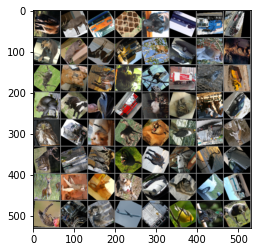

horse  deer   car   cat   dog truck truck truck   cat   cat horse truck monkey   car monkey  deer  deer   dog horse   cat monkey truck  bird truck monkey horse  bird truck  deer   cat horse   car  bird truck   cat  deer   cat  bird truck   dog  deer airplane   dog   dog   cat horse  bird   car  deer monkey   dog   dog   car   dog   car truck  bird horse   dog airplane truck  bird  bird horse


In [32]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(64)))

In [33]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):

    def _name(self):
        return "CNN"

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )

    def _build_models(self):
        self.conv1 = nn.Sequential(
            self._conv2d(self.channels_size, self.hidden_size),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            self._conv2d(self.hidden_size , self.hidden_size * 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size * 2),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size*2, self.hidden_size * 4),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size * 4),
            nn.MaxPool2d(2, 2)
        )
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.hidden_size * 4 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 10),
            nn.Softmax(dim=1),
        )
        return self.conv1, self.conv2, self.conv3, self.dense

    def __init__(self, hidden_size, channels_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.channels_size= channels_size
        self._models = self._build_models()
        self.name = self._name()

    def forward(self, image):
        x = self._models[0](image)
        x_1 = self._models[1](x)
        x_2 = self._models[2](x_1)
        x_3 = self._models[3](x_2)
        return x_3

In [41]:
hidden_size=32
channels_size=3

net=CNN(hidden_size, channels_size)

In [42]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [43]:
epochs=150

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

net.to(device)

cuda:0


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Flatten()
    (1): Linear(in_features=8192, out_featu

In [44]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' %
                  (epoch + 1, running_loss / i))
    running_loss = 0.0

print('Finished Training')
PATH = './stl10_net.pth'
torch.save(net.state_dict(), PATH)

[1] loss: 2.314
[2] loss: 2.258
[3] loss: 2.227
[4] loss: 2.201
[5] loss: 2.192
[6] loss: 2.175
[7] loss: 2.160
[8] loss: 2.152
[9] loss: 2.136
[10] loss: 2.134
[11] loss: 2.132
[12] loss: 2.120
[13] loss: 2.115
[14] loss: 2.110
[15] loss: 2.106
[16] loss: 2.100
[17] loss: 2.093
[18] loss: 2.089
[19] loss: 2.088
[20] loss: 2.076
[21] loss: 2.085
[22] loss: 2.076
[23] loss: 2.071
[24] loss: 2.065
[25] loss: 2.063
[26] loss: 2.063
[27] loss: 2.055
[28] loss: 2.054
[29] loss: 2.050
[30] loss: 2.049
[31] loss: 2.047
[32] loss: 2.045
[33] loss: 2.032
[34] loss: 2.038
[35] loss: 2.037
[36] loss: 2.027
[37] loss: 2.023
[38] loss: 2.018
[39] loss: 2.024
[40] loss: 2.018
[41] loss: 2.011
[42] loss: 2.005
[43] loss: 2.010
[44] loss: 2.003
[45] loss: 2.003
[46] loss: 2.009
[47] loss: 2.000
[48] loss: 1.994
[49] loss: 1.998
[50] loss: 1.994
[51] loss: 1.993
[52] loss: 1.984
[53] loss: 1.989
[54] loss: 1.987
[55] loss: 1.984
[56] loss: 1.983
[57] loss: 1.978
[58] loss: 1.979
[59] loss: 1.977
[60] l

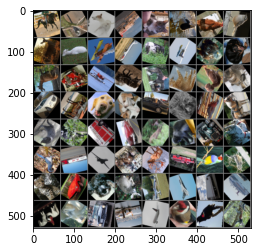

GroundTruth:  horse monkey   dog airplane   cat  bird  bird  bird  deer  deer airplane airplane  deer airplane  bird   dog  deer truck airplane horse   dog   cat  bird   cat   car horse   dog   dog   car monkey  bird horse   cat monkey truck   car  deer monkey truck   dog  bird truck airplane horse  deer truck  bird  bird   cat   car   dog  deer airplane airplane truck  ship horse monkey   car airplane airplane  bird  bird monkey


In [45]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(64)))

In [46]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [47]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 67 %
Accuracy of  bird : 45 %
Accuracy of   car : 64 %
Accuracy of   cat : 38 %
Accuracy of  deer : 42 %
Accuracy of   dog : 33 %
Accuracy of horse : 54 %
Accuracy of monkey : 54 %
Accuracy of  ship : 60 %
Accuracy of truck : 57 %
